In [1]:
"""
Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) 
и приблизить оба эти варианта моделями из класса MA. 
Оценить качество и прислать соображения почему была выбрана та или иная модель
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline

In [2]:
# Инициализируем датасет 
# sales_of_company_jan = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
sales_of_company_1960 = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')
sales_of_company_1960

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587
...,...,...
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180


In [3]:
all_series = {
#     'Monthly sales of company in january': sales_of_company_jan['Count'],
    'Monthly sales of company in 1960': sales_of_company_1960['Count'],
#     'International airline passengers: monthly totals in thousands': airline_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']
}

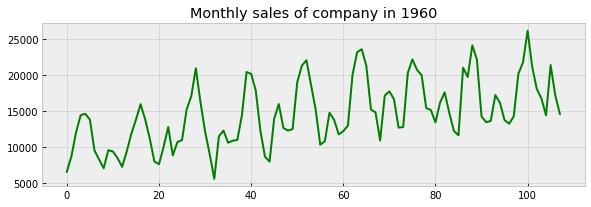

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)                              # компоновка
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))  # гибкий способ расположения графиков с помощью фунции subplot2grid, 
                                                  # которая позволяет занимать графику несколько ячеек таблицы
        all_series[key].plot(ax=ts_ax, color='green')
        ts_ax.set_title(key)
        
    plt.tight_layout()

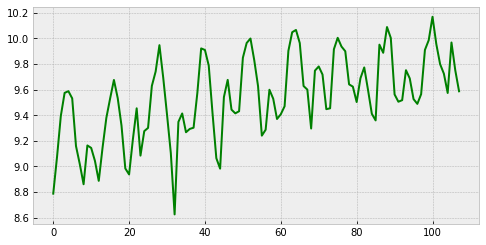

In [5]:
# Судя по изображению ряда, он не является стационарным: возрастает дисперсия, увеличивается мат.ожидание .
# Для начала нормализуем дисперсию. С этой целью применим метод Бокса-Кокса. 
# Метод boxcox возвращает набор данных, обработанный степенным преобразованием Бокса-Кокса

series = boxcox(all_series['Monthly sales of company in 1960'], 0)
with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color='green')

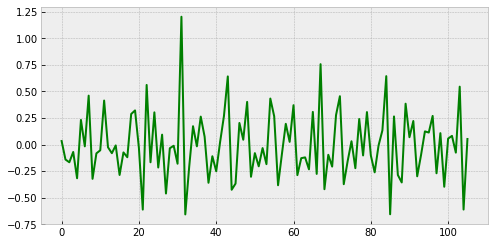

In [6]:
# Продолжим делать ряд стационарным. Попробовав нормализовать дисперсию, произведем дифференцирование ряда, 
# чтобы уравновесть математическое ожидание 
series = np.diff(series, 2)
with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color='green')
# Теперь мы визуально видим: матожидание примерно постоянно, плотность так же, однако скачки дисперсии наблюдаются
# Проведем тест Дики-Фуллера, чтобы понять, насколько ряд соответствует условиям стационарности 

In [11]:
def test_stationarity(timeseries):
    """
    Тест Дики-Фуллера может использоваться для проверки единичного корня 
    в одномерном процессе при наличии последовательной корреляции
    """
    print('Результат теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC') # передаем массив данных для тестирования
                                                 # maxlag: Максимальная задержка, включенная в тест, 
                                                      # по умолчанию 12*(nobs/100)^{1/4}
                                                 # регрессия {"c", "ct", "ctt", "nc"}
                                                      # «C»: только константа (по умолчанию).
                                                      # «Ct»: константа и тренд.
                                                      # «Ctt»: постоянный, линейный и квадратичный тренд.
                                                      # «Nc»: нет константы, нет тенденции
                                                 # autolag {«AIC», «BIC», «t-stat», None}
                                                      # Метод, используемый при автоматическом определении длины лага 
                                                      # среди значений 0, 1,…, maxlag
                                                 # store: Если True, то экземпляр результата возвращается 
                                                      # дополнительно к статистике adf
                                                    # regresults: Если True, возвращаются полные результаты регрессии
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
test_stationarity(series) # показатели для нормализованного ряда
# Получаем статистику, равную -8.277353. Согласно таблице, приведенной ниже, при выборке более 100 
# (в нашем случае 106 наблюдений), всё, что левее значения -2.58, относится к стационарным рядам.
# Можно сделать вывод, что наш ряд является стационарным. 

Результат теста Дики-Фуллера:
Test Statistic                -8.277353e+00
p-value                        4.618013e-13
#Lags Used                     1.300000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


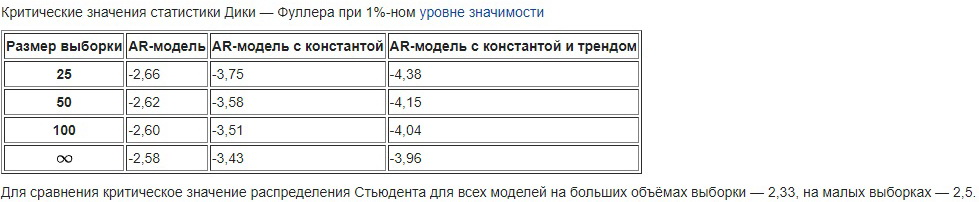

In [14]:
test_stationarity(all_series['Monthly sales of company in 1960'])
# Необработанный ряд подтверждает нулевую гипотезу о том, что ряд не является стационарным 

Результат теста Дики-Фуллера:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [15]:
# Таким образом, имеем дело с двумя типами ряда: станционарным и нестационарым.
# Приблизим оба эти варианта моделями из класса MA. 
# Оценим качество

# Получим для них скользящие средние 
def moving_average(series, n):           # здесь n - окно, которое хотим использовать (количество значений ряда в нем)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()      # .rolling(n) - встроенная функция дл работы со скользящим окном 
                                         # мы применяем к окну усреднение, но можно брать и другие характеристики 
                                         # (дисперсию и проч.)

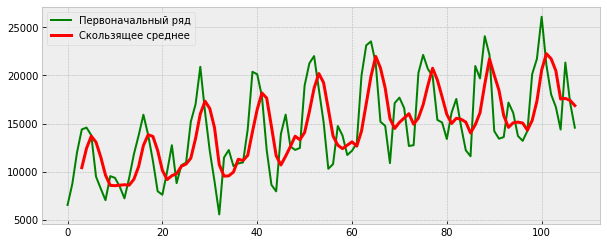

In [21]:
ser = moving_average(sales_of_company_1960['Count'], 4)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 4))
    plt.plot(sales_of_company_1960['Count'], color='green',label='Первоначальный ряд')
    plt.plot(ser, color='red', linewidth='3', label='Скользящее среднее')
    plt.legend()

#Чем больше размер окна, тем менее сглаженный график повторяет контуры оригинального ряда

In [22]:
# Теперь обработаем ряд взвешенным скользящим средним
def weighted_moving_average(series, weights):
    n=len(weights)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

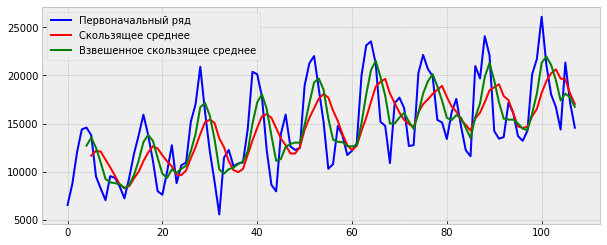

In [31]:
# сравним результаты обработки 
wma = weighted_moving_average(sales_of_company_1960['Count'], [1,2,3,4,5])
ma = moving_average(sales_of_company_1960['Count'], 6)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 4))
    plt.plot(sales_of_company_1960['Count'], color='blue',label='Первоначальный ряд')
    plt.plot(ma, color='red', linewidth='2', label='Скользящее среднее')
    plt.plot(wma, color='green', linewidth='2', label='Взвешенное скользящее среднее')
    plt.legend()
# Очевидно, что размер окна в скользящем среднем значительно влияет на качество интерполяции результата ряда.
# Аналогично: если много весов применять к значениям ряда, то сглаживание также будет слишком глубоким 
# В этой связи можно предложить использовать взвешенное скользящее среднее с меньшим количеством весов
# Либо применять простое сколзящее среднее с не слишком большим размером окна  

In [32]:
# Используем еще одby формат обработки - экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [33]:
ema = exponential_moving_average(sales_of_company_1960['Count'], 0.2)

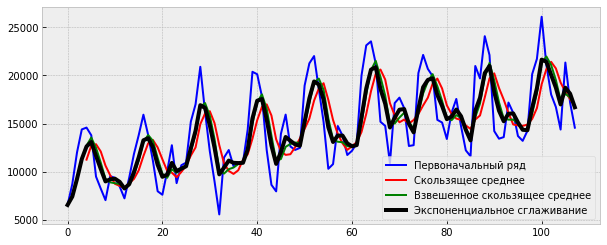

In [37]:
# Построим графики на основе трех моделей
ema = exponential_moving_average(sales_of_company_1960['Count'], 0.4)
wma = weighted_moving_average(sales_of_company_1960['Count'], [1,2,3,4,5])
ma = moving_average(sales_of_company_1960['Count'], 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 4))
    plt.plot(sales_of_company_1960['Count'], color='blue',label='Первоначальный ряд')
    plt.plot(ma, color='red', linewidth='2', label='Скользящее среднее')
    plt.plot(wma, color='green', linewidth='2', label='Взвешенное скользящее среднее')
    plt.plot(ema, color='black', linewidth='4', label='Экспоненциальное сглаживание')
    plt.legend()
# Чем выше показатель альфа, тем график экспоненциального сглаживния ближе повторяет первоначальный
# Здесь мы видим, что при заданных переметрах экспоненциальное сглаживание и взвешенное скользящее среднее 
# фактически - один график

In [38]:
# Далее применим функцию двойного экспоненциального сглаживания
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [40]:
# Создадим объект данной функции
dema = double_ema(sales_of_company_1960['Count'], 0.2, 0.2)

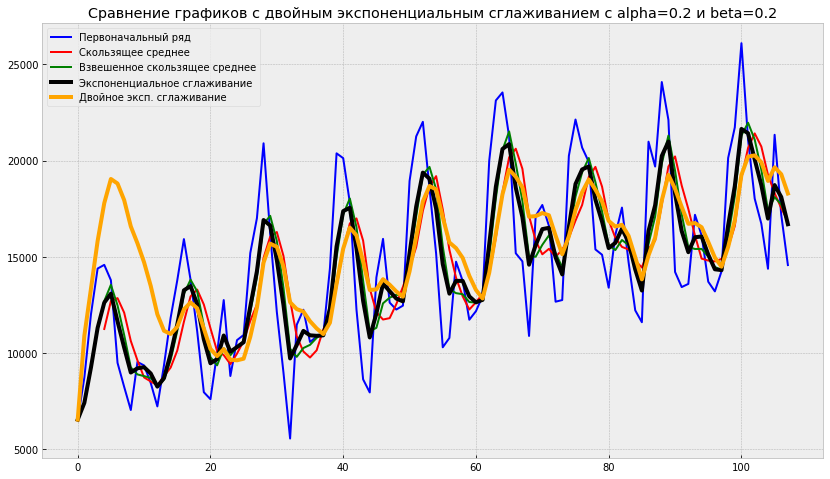

In [58]:
with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_1960['Count'], color='blue',label='Первоначальный ряд')
        plt.plot(ma, color='red', linewidth='2', label='Скользящее среднее')
        plt.plot(wma, color='green', linewidth='2', label='Взвешенное скользящее среднее')
        plt.plot(ema, color='black', linewidth='4', label='Экспоненциальное сглаживание')
        plt.plot(dema, color='orange', linewidth='4', label='Двойное эксп. сглаживание')
        plt.title(f'Сравнение графиков с двойным экспоненциальным сглаживанием с alpha={0.2} и beta={0.2}')
        plt.legend()

In [47]:
# Попробуем учесть сезонную компоненту - применим тройное экспоненциальное сглаживание (метод Хольта-Винтерса)

def initial_trend(series, season_len):    # здесь season_len - длина сезона
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [48]:
def initial_seasonal_components(series, slen):   # здесь slen - длина сезона
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)            # считаем количество сезонов
              
    for j in range(n_seasons):                   # j- номер сезона
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen)) # значение в скобках - среднее внутри сезона
    
    for i in range(slen):                        # i - перебираем месяцы сезона (их номера) 
        sum_of_vals_over_avg = 0.0               # объявляем счетчик 
        for j in range(n_seasons):               # j- перебираем количество сезонов
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]  # series[slen*j+i] - смещение по временному ряду 
                                                                          # внутри сезона: от каждого месяца внутри сезона
                                                              # вычитается среднее по сезону и результат заносится в сумму
                                                                # sum_of_vals_over_avg
        seasonals[i] = sum_of_vals_over_avg/n_seasons    # полученная сумма делится на количество сезонов
    return seasonals

In [49]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds): # n_preds - количество предсказаний,
                                                                              # которое хотим сделать
    result = []
    seasonals = initial_seasonal_components(series, slen)
    
    for i in range(len(series)+n_preds):
        if i == 0:                              # первоначальные значения
            smooth = series[0]                  # smooth - компонента сглаживания 
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):                   # прогнозируем
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])  # [i%slen] - далее длины сезона не пройдем
        else:
            val = series[i]                   # текущее значение временного ряда
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend) # seasonals[i%slen] - 
                                                                                          # сезонная компонента, например, июль
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [50]:
# Применим функции поиска сезонности
def plot_ts_and_points(ts, start_point, step):
    """
    Функция для поиска сезонности во временных рядах
    """
    new_series = [None for i in range(len(ts))]  
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='green')
        new_series.plot(ax=ts_ax, style='ro')

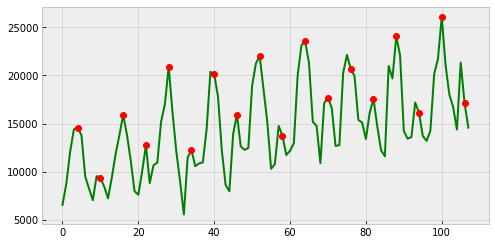

In [51]:
plot_ts_and_points(sales_of_company_1960['Count'], 4, 6)
# примерно каждые полгода - экстремумы в точках: цикл завершается за 12 месяцев

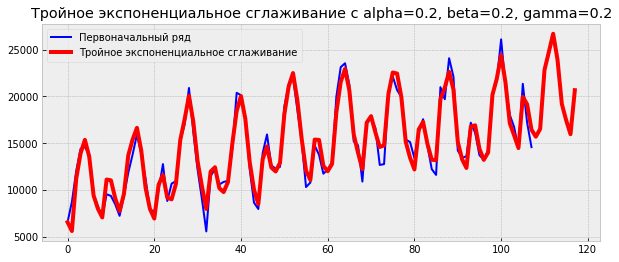

In [60]:
tema = triple_exponential_smoothing(sales_of_company_1960['Count'], 12, 0.2, 0.2, 0.2, 10)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 4))
    plt.plot(sales_of_company_1960['Count'], color='blue',label='Первоначальный ряд')
    plt.plot(tema, color='red', linewidth='4', label='Тройное экспоненциальное сглаживание')
    plt.title(f'Тройное экспоненциальное сглаживание с alpha={0.2}, beta={0.2}, gamma={0.2}')
    plt.legend()

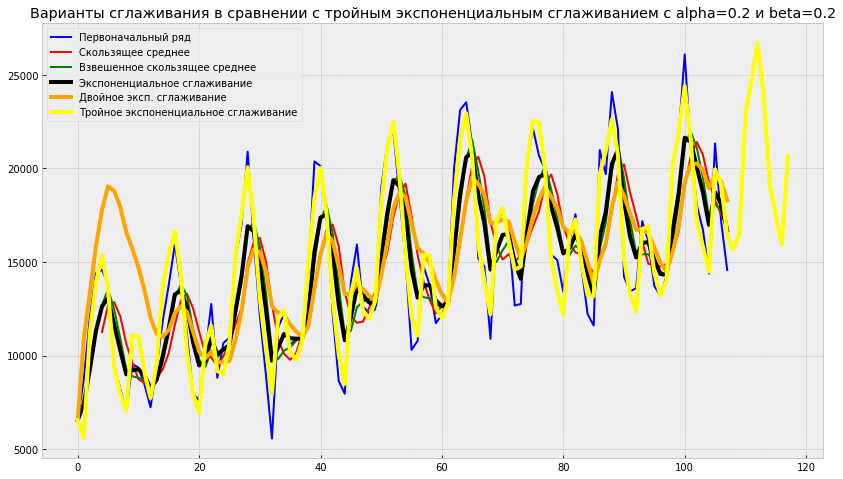

In [61]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_1960['Count'], color='blue',label='Первоначальный ряд')
    plt.plot(ma, color='red', linewidth='2', label='Скользящее среднее')
    plt.plot(wma, color='green', linewidth='2', label='Взвешенное скользящее среднее')
    plt.plot(ema, color='black', linewidth='4', label='Экспоненциальное сглаживание')
    plt.plot(dema, color='orange', linewidth='4', label='Двойное эксп. сглаживание')
    plt.plot(tema, color='yellow', linewidth='4', label='Тройное экспоненциальное сглаживание')
    plt.title(f'Варианты сглаживания в сравнении с тройным экспоненциальным сглаживанием с alpha={0.2} и beta={0.2}')
    plt.legend()
# Т.к. сезонность в ряду присутствует, последний использованный метод дал хороший результат

In [ ]:
# Как видим, различные использованные методы применимы при соответствующем подборе их параметров
# Мы не делаем в данном случае предпочтений, отмечая, что тройное эксп. сглаживание при заданных параметрах альфа, 
# бета и гамма, 
# а также при наличии тренда и сезонности дает хорошие показатели соответствия ряду и экстраполяции значений в будущее 